## Introducción

##### ¿Qué son los terremotos?

Los terremotos ocurren cuando hay una liberación repentina de energía en el interior de la Tierra. Esto sucede porque las placas tectónicas —grandes bloques que forman la corteza terrestre— están en constante movimiento. Sin embargo, con el tiempo, pueden quedar atascadas en los bordes debido a la fricción. Cuando la fuerza acumulada supera la resistencia, se produce un "deslizamiento" que causa el terremoto. La energía liberada se propaga en forma de ondas, provocando los temblores que sentimos.

Según el Centro Nacional de Información sobre Terremotos (NEIC), se registran alrededor de 20 mil terremotos al año en todo el mundo —un promedio de 55 por día. Este número no significa que los terremotos estén aumentando, sino que los equipos de medición han mejorado y se han distribuido más ampliamente, lo que permite detectar incluso los temblores más débiles.

De acuerdo con los registros históricos desde 1900, se espera un promedio de 16 grandes terremotos al año, siendo 15 de ellos con una magnitud cercana a 7.0 y uno con magnitud de 8.0 o superior. Algunos años superaron ese promedio, como en 2010, que registró 23 grandes terremotos. Otros años, como 1988 y 1989, estuvieron muy por debajo del promedio.

La profundidad del epicentro también influye en la intensidad del temblor que se siente en la superficie. Un terremoto a 500 km de profundidad, por ejemplo, tiende a causar menos impacto que uno con la misma magnitud a solo 20 km de profundidad. Sin embargo, determinar la profundidad con precisión es más difícil que determinar la ubicación del evento, especialmente cuando no hay una estación sísmica cercana.

Aunque muchos terremotos son superficiales, algunos ocurren a grandes profundidades. De hecho, cuando no hay suficientes datos para determinar la profundidad con precisión, los científicos suelen adoptar un valor estándar: 10 km, ya que es el valor promedio más común en varias regiones del mundo.

La magnitud es la medida más conocida para indicar el tamaño de un terremoto. Es un número único que representa la energía liberada en el origen del evento —independientemente del lugar donde se encuentre la persona.

Por último, es importante saber que, hasta hoy, ningún gran terremoto ha sido predicho con antelación por la ciencia. A pesar de todos los avances, los terremotos siguen siendo eventos naturales difíciles de prever, lo que refuerza la importancia del monitoreo constante.

## Objetivo

El objetivo de este proyecto fue recopilar datos sobre terremotos directamente desde la API pública del USGS (Servicio Geológico de los Estados Unidos), disponible en https://earthquake.usgs.gov/fdsnws/event/1/ y realizar un análisis exploratorio utilizando Python.

A partir de estos datos, buscamos entender patrones como la frecuencia, ubicación, profundidad y magnitud de los terremotos ocurridos entre 2023 y 2024.
Además, construimos un panel interactivo (dashboard) con la biblioteca Streamlit para facilitar la visualización e interpretación de los resultados.

#### Importando Bibliotecas

In [83]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
import plotly.express as px

#### Recolección de datos desde la API

In [45]:
# Parâmetros da API com limite reduzido
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2023-01-01",
    "endtime": "2024-12-31",
    "limit": 20000,
    "minmagnitude": 4.5
}

# Requisição
response = requests.get(url, params=params)
print("Status da requisição:", response.status_code)

if response.status_code == 200:
    data = response.json()
    print("Total de terremotos encontrados:", len(data['features']))

    # Conversão para DataFrame
    earthquakes = []
    for feature in data["features"]:
        props = feature["properties"]
        coords = feature["geometry"]["coordinates"]
        earthquakes.append({
            "data_hora": pd.to_datetime(props["time"], unit='ms'),
            "local": props["place"],
            "magnitude": props["mag"],
            "longitude": coords[0],
            "latitude": coords[1],
            "profundidade_km": coords[2],
            "tipo": props["type"],
            "link_evento": props["url"]
        })

Status da requisição: 200
Total de terremotos encontrados: 14036


In [84]:
#Creando DataFrame
df_copy = pd.DataFrame(earthquakes)
df_copy.head()

,data_hora,local,magnitude,longitude,latitude,profundidade_km,tipo,link_evento
0,2024-12-30 23:56:29.977,"80 km NW of Kandrian, Papua New Guinea",4.6,148.9729,-5.7603,127.013,earthquake,https://earthquake.usgs.gov/earthquakes/eventp...
1,2024-12-30 23:40:33.868,"247 km ENE of Levuka, Fiji",4.6,-178.3937,-17.6089,573.817,earthquake,https://earthquake.usgs.gov/earthquakes/eventp...
2,2024-12-30 23:30:59.974,"24 km N of Metahāra, Ethiopia",4.7,39.9276,9.1189,10.000,earthquake,https://earthquake.usgs.gov/earthquakes/eventp...
3,2024-12-30 23:16:09.495,"181 km WNW of Pangai, Tonga",4.6,-175.9927,-19.2777,10.000,earthquake,https://earthquake.usgs.gov/earthquakes/eventp...
4,2024-12-30 22:13:14.697,"22 km NW of Āwash, Ethiopia",4.8,40.0367,9.1373,10.000,earthquake,https://earthquake.usgs.gov/earthquakes/eventp...


In [47]:
#Creando copia del DF
df = df_copy.copy()

#### Análisis Exploratorio

In [48]:
#Verificar estrutura geral do dataframe
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14036 entries, 0 to 14035
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data_hora        14036 non-null  datetime64[ns]
 1   local            14036 non-null  object        
 2   magnitude        14036 non-null  float64       
 3   longitude        14036 non-null  float64       
 4   latitude         14036 non-null  float64       
 5   profundidade_km  14036 non-null  float64       
 6   tipo             14036 non-null  object        
 7   link_evento      14036 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 877.4+ KB


Tenemos 14036 entradas, 8 columnas e ningún valor nulo.

Para facilitar el análisis, vamos crear columnas: mes, año y hora. Además, eliminaremos la columna link_evento, ya que no será necesaria en este análisis, y separaremos el país de la columna local.

In [49]:
#Criar coluna com o mês
df['mes'] = df['data_hora'].dt.month

# Criar coluna com o ano
df['ano'] = df['data_hora'].dt.year

# Criar uma coluna só com a hora
df['hora'] = df['data_hora'].dt.time

In [50]:
# Remover a coluna link_evento
df = df.drop(columns=['link_evento'])

In [51]:
# Separar país na coluna local
df['pais'] = df['local'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else x)

Si visualizamos la columna tipo, veremos que existe earthquake (terremoto) y volcanic eruption (erupción volcánica) que, aunque no es un terremoto, su erupción puede causar pequeños temblores.
Sin embargo, para fines de análisis, vamos filtrar únicamente los terremotos.

In [52]:
df = df[df['tipo'] == 'earthquake']

In [53]:
df.head(3)

,data_hora,local,magnitude,longitude,latitude,profundidade_km,tipo,mes,ano,hora,pais
0,2024-12-30 23:56:29.977,"80 km NW of Kandrian, Papua New Guinea",4.6,148.9729,-5.7603,127.013,earthquake,12,2024,23:56:29.977000,Papua New Guinea
1,2024-12-30 23:40:33.868,"247 km ENE of Levuka, Fiji",4.6,-178.3937,-17.6089,573.817,earthquake,12,2024,23:40:33.868000,Fiji
2,2024-12-30 23:30:59.974,"24 km N of Metahāra, Ethiopia",4.7,39.9276,9.1189,10.000,earthquake,12,2024,23:30:59.974000,Ethiopia


##### Análisis descriptivo de la magnitud y profundidad de los terremotos

In [56]:
df[['magnitude', 'profundidade_km']].describe()

,magnitude,profundidade_km
count,14028.000000,14028.000000
mean,4.799861,63.682805
std,0.371125,113.065843
min,4.500000,1.358000
25%,4.500000,10.000000
50%,4.700000,14.000000
75%,4.900000,62.469000
max,7.800000,653.779000


*Magnitud*

* La magnitud promedio es de 4.8;

* La desviación estándar es de 0.371, lo que indica una baja dispersión de los datos, es decir, la mayoría de las magnitudes están cerca del promedio;

* El valor mínimo (preestablecido) fue de 4.5 y el valor máximo de 7.8;

* El 25% de los terremotos tienen una magnitud menor o igual a 4.5;

* El 75% de los terremotos tienen una magnitud menor o igual a 4.9;

* La mediana de las magnitudes es 4.7, un poco menor que la media (4.8), lo que sugiere una distribución levemente asimétrica hacia la derecha.

*Profundidad*

* La profundidad promedio es de 63.65 km;

* La desviación estándar de 113 indica una alta dispersión, lo que muestra que la profundidad de los terremotos varía bastante;

* El valor mínimo de profundidad es de 1.35 km y el máximo de 653.779 km;

* El 25% de los terremotos tienen una profundidad menor o igual a 10 km;

* La mediana es de 14 km, menor que la media, lo que también sugiere una distribución asimétrica hacia la derecha;

* El 75% de los terremotos tienen una profundidad menor o igual a 62.46 km. La mayoría de los terremotos ocurren en capas superficiales o intermedias, con una minoría en profundidades muy elevadas.



##### Análisis de la distribución de la magnitud y la profundidad

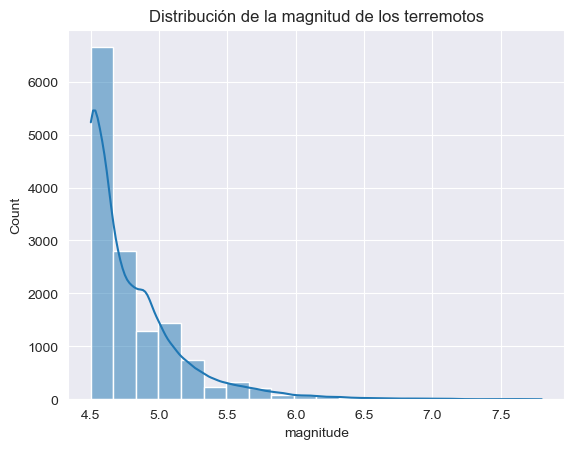

In [85]:
sns.histplot(df['magnitude'], bins=20, kde=True)
plt.title("Distribución de la magnitud de los terremotos")
plt.show()

Vemos que os valores da magnitude se concentram entre 4.5 e 5.0 e poucos valores acima de 5.5. Valores do lado esquerdo (calda à direita - assimetria positiva) sugere que a média dos dados é maior do que a mediana. 

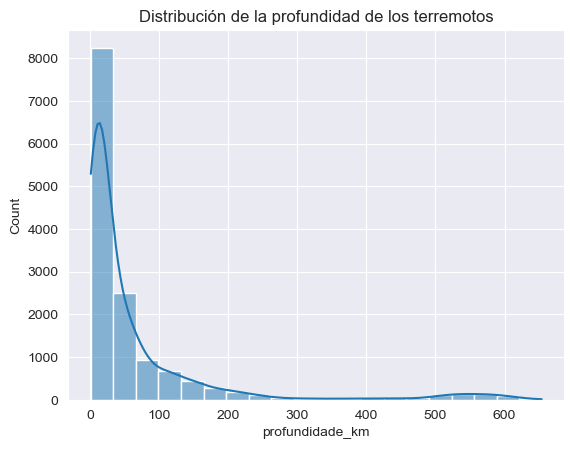

In [87]:
sns.histplot(df['profundidade_km'], bins=20, kde=True)
plt.title("Distribución de la profundidad de los terremotos")
plt.show()

Aquí, nuevamente, vemos una concentración de valores hacia la izquierda, lo que indica que la mayoría de los terremotos están concentrados en profundidades bajas.

##### Correlación entre Magnitud y Profundidad

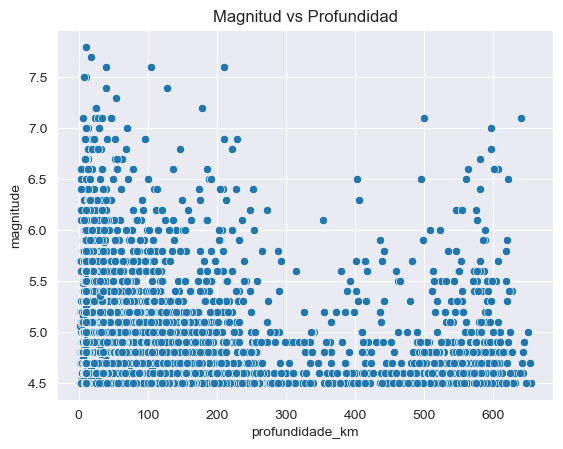

                 magnitude  profundidade_km
magnitude         1.000000        -0.010338
profundidade_km  -0.010338         1.000000


In [86]:
sns.scatterplot(x='profundidade_km', y='magnitude', data=df)
plt.title('Magnitud vs Profundidad')
plt.show()

print(df[['magnitude', 'profundidade_km']].corr())

Los puntos están bastante dispersos y no parece haber una relación clara entre la magnitud y la profundidad de los terremotos. Con la función corr(), identificamos una correlación de -0.01, un valor muy cercano a cero, lo que indica una correlación prácticamente nula entre estas dos variables.

Esto significa que no existe una relación lineal significativa entre la profundidad del epicentro y la magnitud de los terremotos en los datos analizados. En otras palabras, los terremotos más profundos no tienden a ser más fuertes, y los más superficiales no tienden a ser más débiles.

Este resultado refuerza la información divulgada por el USGS, que indica que la profundidad influye principalmente en la intensidad del temblor percibido en la superficie, y no en su magnitud. Por ejemplo, un terremoto a 500 km de profundidad puede causar menos impacto que otro con la misma magnitud a solo 20 km de profundidad.

##### Analizando la cantidad de terremotos por año

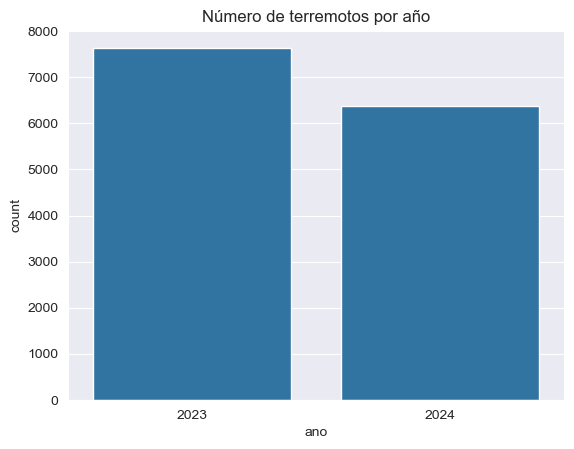

ano
2023    7643
2024    6385
Name: count, dtype: int64


In [88]:
# Contagem por ano
sns.countplot(x='ano', data=df)
plt.title('Número de terremotos por año')
plt.show()

print(df['ano'].value_counts())

El año 2023 registró un mayor número de terremotos en comparación con 2024.


##### Análisis de la cantidad de terremotos por mes

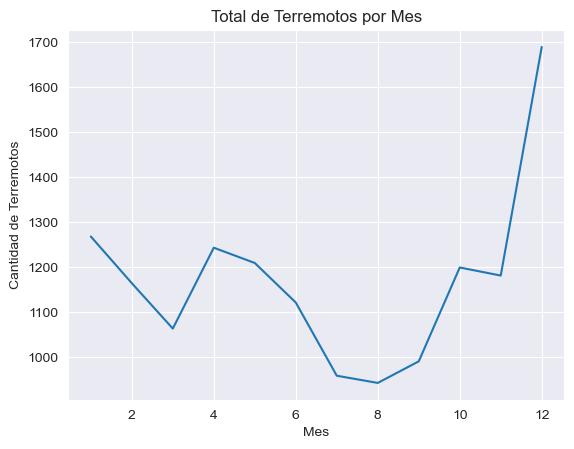

In [89]:
# Contar terremotos por mês
contagem_mes = df['mes'].value_counts().sort_index()

# Transformar em DF para plotar
df_mes = contagem_mes.reset_index()
df_mes.columns = ['mes', 'contagem']

# Plotar
sns.lineplot(data=df_mes, x='mes', y='contagem')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Terremotos')
plt.title('Total de Terremotos por Mes')
plt.show()

Al analizar los datos de terremotos, observamos que la mayor cantidad de sismos ocurre en el mes de diciembre. En cambio, en los meses de julio y agosto, la actividad sísmica es menor. Esto no significa necesariamente que haya una causa directa relacionada con las estaciones del año, ya que los terremotos son fenómenos naturales que dependen del movimiento de las placas tectónicas, las cuales no siguen un patrón anual definido.

Sin embargo, observar esta variación mensual ayuda a comprender mejor los períodos de mayor riesgo y puede ser útil para la preparación y el monitoreo de las regiones más afectadas.

##### Análisis de la hora con mayor frecuencia de terremotos

In [65]:
# Converter a coluna hora de object para datetime
df['hora_convertida'] = pd.to_datetime(df['hora'], format='%H:%M:%S.%f', errors='coerce')
print(df[['hora', 'hora_convertida']].head(10))

              hora         hora_convertida
0  23:56:29.977000 1900-01-01 23:56:29.977
1  23:40:33.868000 1900-01-01 23:40:33.868
2  23:30:59.974000 1900-01-01 23:30:59.974
3  23:16:09.495000 1900-01-01 23:16:09.495
4  22:13:14.697000 1900-01-01 22:13:14.697
5  20:33:11.322000 1900-01-01 20:33:11.322
6  20:27:35.490000 1900-01-01 20:27:35.490
7  18:50:47.010000 1900-01-01 18:50:47.010
8  15:27:54.586000 1900-01-01 15:27:54.586
9  15:25:58.372000 1900-01-01 15:25:58.372


In [ ]:
df['hora'] = df['hora_convertida'].dt.hour #deixando somente a coluna hora após verificar que a coluna estava correta. 
df.drop(columns='hora_convertida', inplace=True)

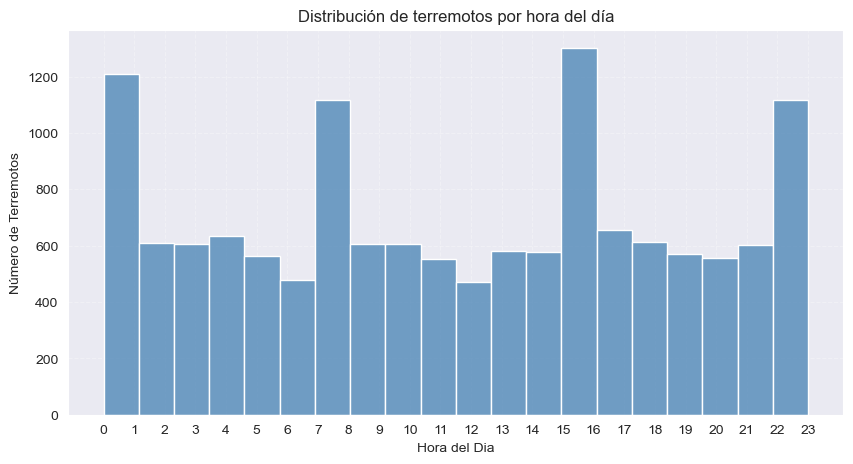

In [90]:
# Criar gráfico
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='hora', bins=20, kde=False, color='steelblue')
plt.title('Distribución de terremotos por hora del día')
plt.xlabel('Hora del Dia')
plt.ylabel('Número de Terremotos')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Al analizar los horarios de los terremotos registrados, observamos picos de ocurrencia entre las 0:00–1:00, 7:00–8:00, 15:00–16:00 y 22:00–23:00. Estos intervalos concentran la mayor cantidad de eventos sísmicos, con aproximadamente entre 1.100 y 1.200 registros en cada franja horaria.

Aunque los terremotos no dependen de una hora específica para ocurrir, estos patrones pueden reflejar zonas tectónicas más activas o diferencias en los husos horarios y los registros a nivel global. Este tipo de patrón es útil para el monitoreo y la modelización de datos sísmicos.

##### Aspectos del terremoto de mayor magnitud

In [73]:
df[df['magnitude'] == 7.8]

,data_hora,local,magnitude,longitude,latitude,profundidade_km,tipo,mes,ano,hora,pais
13314,2023-02-06 01:17:34.342,"Pazarcik earthquake, Kahramanmaras earthquake ...",7.8,37.0143,37.2256,10.0,earthquake,2,2023,1.0,Kahramanmaras earthquake sequence


Entre 2023 e 2024, o terremoto de maior magnitude foi em 2023 na cidade de Kahramanmaraş, localizada na região sudeste da Turquia, com uma magnitude de 7.8 e profundidade de 10 km. 

In [74]:
# Explorar terremotos dessa região
df[df["pais"] == "Kahramanmaras earthquake sequence"]

,data_hora,local,magnitude,longitude,latitude,profundidade_km,tipo,mes,ano,hora,pais
13261,2023-02-06 10:24:48.811,"Elbistan earthquake, Kahramanmaras earthquake ...",7.5,37.1962,38.0106,7.432,earthquake,2,2023,10.0,Kahramanmaras earthquake sequence
13314,2023-02-06 01:17:34.342,"Pazarcik earthquake, Kahramanmaras earthquake ...",7.8,37.0143,37.2256,10.000,earthquake,2,2023,1.0,Kahramanmaras earthquake sequence


Entre 2023 y 2024, el terremoto de mayor magnitud ocurrió en 2023 en la ciudad de Kahramanmaraş, ubicada en la región sureste de Turquía, con una magnitud de 7.8 y una profundidad de 10 km.
En esta región, se registraron dos eventos sísmicos: uno a la 01:17 y otro a las 10:24, ambos con magnitudes elevadas. Estos datos corresponden a los terremotos de 2023, considerados los más intensos registrados en Turquía desde 1939. El país se encuentra en una de las zonas sísmicas más activas del mundo, lo que contribuye a la frecuencia e intensidad de estos fenómenos.

##### Aspectos del terremoto de mayor profundidad

In [75]:
df[df['profundidade_km'] == 653.779000]

,data_hora,local,magnitude,longitude,latitude,profundidade_km,tipo,mes,ano,hora,pais
2565,2024-07-29 00:59:46.346,south of the Fiji Islands,4.5,178.6793,-24.3159,653.779,earthquake,7,2024,0.0,south of the Fiji Islands


En los datos analizados, el terremoto más profundo registrado alcanzó los 653 km bajo la superficie de la Tierra. A pesar de la profundidad impresionante, su magnitud fue de solo 4.5 — considerada moderada.

Esto demuestra que la profundidad de un terremoto no está directamente relacionada con su fuerza (magnitud). Es decir, un terremoto superficial puede ser mucho más intenso que uno profundo. La profundidad influye más en la forma en que se percibe el temblor en la superficie que en la cantidad de energía liberada. Los terremotos muy profundos, al estar más alejados de la superficie, suelen causar menos impacto en las zonas habitadas, incluso cuando tienen una magnitud alta.

##### 10 lugares con mayor número de terremotos entre 2023 y 2024

In [76]:
# Ver quantos locais únicos
print(f"Locais únicos: {df['local'].nunique()}")

# Quais os 10 locais com mais terremotos?
top_locais = df['local'].value_counts().head(10)
print(top_locais)

Locais únicos: 8817
local
South Sandwich Islands region                    438
south of the Fiji Islands                        280
Izu Islands, Japan region                        277
Kermadec Islands region                          269
southeast of the Loyalty Islands                 257
Kermadec Islands, New Zealand                    179
Mid-Indian Ridge                                 175
Volcano Islands, Japan region                    148
Maug Islands region, Northern Mariana Islands    135
Fiji region                                      134
Name: count, dtype: int64


Podemos observar que básicamente tenemos islas en nuestra lista. Muchas islas se encuentran ubicadas en los bordes de las placas tectónicas — grandes "fragmentos" de la corteza terrestre que están en constante movimiento. En estas regiones, las placas pueden chocar, deslizarse una sobre otra o alejarse, causando temblores.

Por eso, áreas con muchas islas, como las Islas Sandwich del Sur, Fiji, Japón y las Islas Marianas, suelen registrar más terremotos. Estas regiones se llaman “zonas sísmicas activas” porque los movimientos de las placas son más intensos en esas áreas.



##### Visualización de terremotos con magnitud superior a 6.5

Vamos a visualizar en el mapa mundial las regiones donde ocurrieron terremotos con magnitud superior a 6.5.

In [77]:
df_filtrado = df[df['magnitude'] > 6.5]

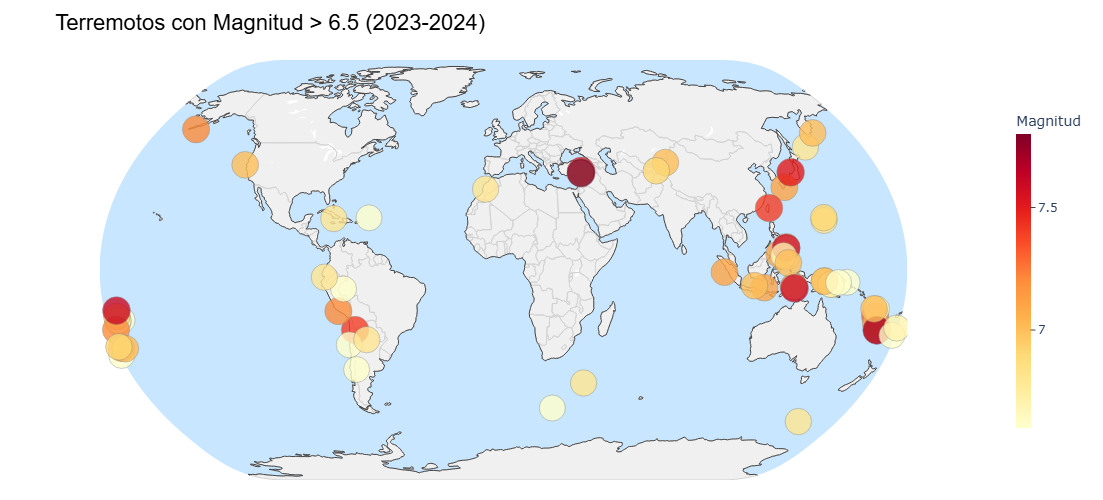

In [98]:
fig = px.scatter_geo(
    df_filtrado,
    lat='latitude',
    lon='longitude',
    color='magnitude',
    hover_name='local',
    size='magnitude',
    projection='natural earth',
    title='Terremotos con Magnitud > 6.5 (2023-2024)',
    color_continuous_scale='YlOrRd',  
    template='plotly_white'           
)

fig.update_layout(
    geo=dict(
        showland=True,
        landcolor='rgb(240, 240, 240)', 
        showocean=True,
        oceancolor='rgb(200, 230, 255)',
        showframe=False,
        showcountries=True,
        countrycolor='lightgray'
    ),
    width=1100,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    title_font=dict(size=22, family='Arial', color='black'),
    coloraxis_colorbar=dict(
        title='Magnitud',
        ticks='outside',
        tickvals=[6.5, 7, 7.5, 8],
        len=0.8,
        thickness=15,
        tickfont=dict(size=12)
    )
)

fig.update_traces(
    marker=dict(
        line=dict(width=0.5, color='gray'),
        sizemode='area',
        opacity=0.8
    )
)

fig.show()

Al observar el mapa, notamos que la mayor concentración de terremotos con magnitud superior a 6.5 se encuentra en la región conocida como el Cinturón de Fuego. Esta región es famosa por tener una alta actividad tectónica y, en consecuencia, una alta incidencia de terremotos de diferentes intensidades.

##### Clasificación de los terremotos por categoría de magnitud

Según la Escala de Richter, los terremotos se clasifican de <1 a 10 (siendo 10 un valor convencional, aunque no existe un límite máximo en la escala). Donde:

4.0 a 4.9 - Ligero

5.0 a 5.9 - Moderado

6.0 a 6.9 - Fuerte

7.0 a 7.9 - Muy fuerte

8.0 a 8.9 - Destructivo

9.0 a 9.9 - Devastador

10+ - Muy devastador

¡Vamos a agrupar estos valores y ver cuál es la escala más frecuente!

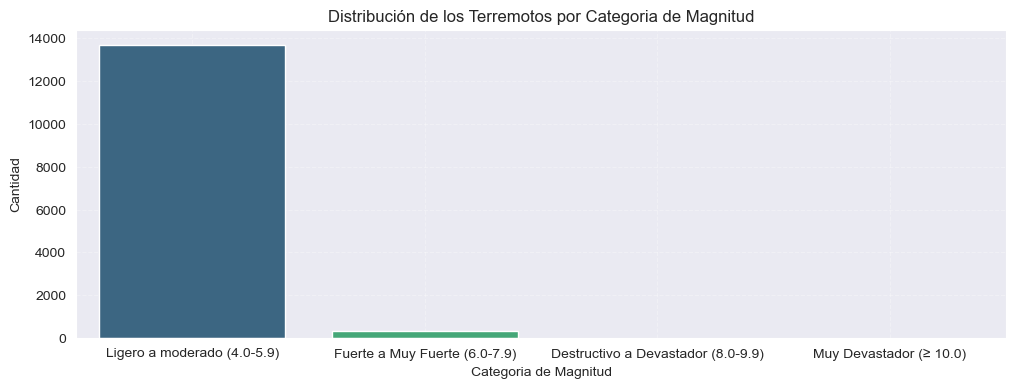

In [96]:
# Definir categorias de magnitude
def classificar_magnitude(mag):
    if mag < 5.9:
        return 'Ligero a moderado (4.0-5.9)'
    elif mag < 7.9:
        return 'Fuerte a Muy Fuerte (6.0-7.9)'
    elif mag < 9.9:
        return 'Destructivo a Devastador (8.0-9.9)'
    else:
        return 'Muy Devastador (≥ 10.0)'

# Criar a nova coluna
df['categoria_magnitude'] = df['magnitude'].apply(classificar_magnitude)

# Contar e plotar
plt.figure(figsize=(12,4))
sns.countplot(data=df, x='categoria_magnitude', order=['Ligero a moderado (4.0-5.9)', 'Fuerte a Muy Fuerte (6.0-7.9)', 'Destructivo a Devastador (8.0-9.9)', 'Muy Devastador (≥ 10.0)'], palette='viridis', hue='categoria_magnitude', legend=False)
plt.title('Distribución de los Terremotos por Categoria de Magnitud')
plt.xlabel('Categoria de Magnitud')
plt.ylabel('Cantidad')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

La mayoría de los terremotos registrados se encuentran en las categorías de ligero a moderado, es decir, son temblores que generalmente no causan grandes daños. Solo una pequeña parte alcanza las categorías de fuerte a muy fuerte, que pueden ser más peligrosas dependiendo de la ubicación y profundidad. Ningún terremoto registrado en el período analizado llegó a los niveles más extremos, como destructivo, devastador o muy devastador — los cuales son raros y suelen causar grandes perjuicios.

## Conclusión

El análisis exploratorio de los terremotos registrados entre 2023 y 2024 reveló patrones importantes sobre la actividad sísmica global. La mayoría de los eventos fueron de magnitud baja a moderada, lo que indica que, en general, causan pocos o ningún daño. No se registraron terremotos clasificados como destructivos, devastadores o muy devastadores durante este período.

Aunque algunos terremotos ocurrieron a grandes profundidades, se observó que no existe una relación lineal entre profundidad y magnitud; es decir, los terremotos profundos no son necesariamente más fuertes. Se puede afirmar que los terremotos más profundos tienden a sentirse menos en la superficie, incluso si presentan una fuerza similar a la de los terremotos superficiales.

Al analizar la cantidad de terremotos a lo largo del tiempo, se notó una actividad ligeramente mayor en diciembre, mientras que julio y agosto registraron el menor número de eventos. El análisis geográfico indicó que las regiones insulares y las cercanas a los límites de las placas tectónicas, como el sur de las Islas Sandwich, Fiji, Japón y Kermadec, concentran la mayor parte de la actividad sísmica, lo cual es esperado dado que estas zonas se encuentran sobre áreas de convergencia de placas.

Finalmente, visualizaciones como el mapa interactivo permiten localizar con precisión los eventos más significativos (con magnitud superior a 6.5), facilitando una mejor comprensión espacial de los riesgos sísmicos.

Aunque aún no es posible predecir exactamente cuándo ocurrirá un terremoto, conocer sus patrones, las regiones más afectadas y entender la dinámica de estos fenómenos contribuye al desarrollo de planes de acción y medidas preventivas, especialmente en áreas más vulnerables.

*Enlaces útiles*

Para seguir los terremotos en tiempo real:
https://earthquake.usgs.gov/earthquakes/map/?extent=21.45307,-130.16602&extent=52.13349,-59.85352

Para obtener información sobre terremotos y otros eventos geológicos:
https://www.usgs.gov/programs/earthquake-hazards/faqs-category

**Salvar arquivo en formato .parquet para creación del Dashboard en Streamlit**

In [82]:
df.to_parquet("terremotos.parquet", index= False)